In [259]:
import h5py
from matplotlib import pyplot as plt
import numpy as np
from pprint import pprint
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,roc_curve, auc
from os import listdir
import itertools
from sklearn.preprocessing import label_binarize
from PIL import Image
from sklearn.model_selection import KFold
from scipy import interp
from itertools import cycle
%matplotlib inline 

In [45]:
def get_dataset(file_number):
    dataset_file_object = h5py.File(f"data_{file_number}.h5",'r')
    return dataset_file_object.get('x').value,dataset_file_object.get('y').value

In [46]:
def plot_dataset(X,Y):
    plt.scatter(X[:,0], X[:,1], c=Y)
    plt.xlabel('X')
    plt.ylabel('Y')

In [47]:
def get_number_of_sample(X):
    return X.shape[0]

In [48]:
def get_class_counts(Y):
    unique, counts = np.unique(Y,return_counts=True)
    return dict(zip(unique,counts))

In [49]:
def describe_dataset(dataset_number):
    X,Y = get_dataset(dataset_number)
    print(f'Number of samples in dataset are {get_number_of_sample(X)}')
    print('Classes and respective number of samples')
    pprint(get_class_counts(Y))
    plot_dataset(X,Y)

# Question 1

## Part (i)

Number of samples in dataset are 100
Classes and respective number of samples
{0: 50, 1: 50}


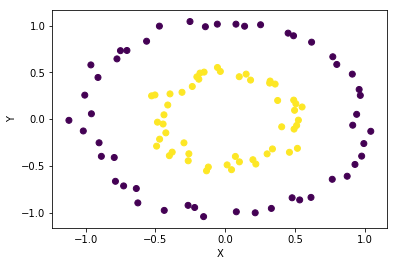

In [50]:
describe_dataset(1)

- **Class_balance** = Both classes are balanced.
- **Separability** = Samples are roughly arranged as concentric circles, therefore we would need a circular decision boundry.
- **Noise** = Their is no noise in dataset.

Number of samples in dataset are 100
Classes and respective number of samples
{0: 50, 1: 50}


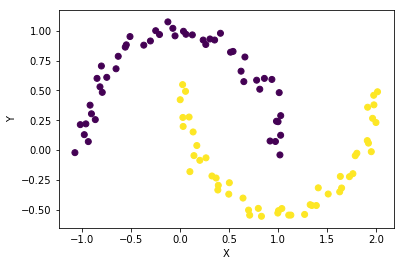

In [51]:
describe_dataset(2)

- **Class balance** = Both classes are balanced.
- **Separability** = Samples are roughly arranged as two quadratics, therefore we would need a poloynomial decision boundry.
- **Noise** = Their is no noise in dataset.

Number of samples in dataset are 100
Classes and respective number of samples
{0: 34, 1: 33, 2: 33}


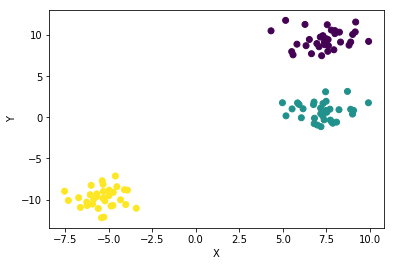

In [52]:
describe_dataset(3)

- **Class_balance** = All three classes are balanced (0 has one more sample then 1 and 2).
- **Separability** = Samples are roughly arranged as 3 different segments of space, and are linearly seprable with help of one-vs-all/one-vs-one
- **Noise** = Their is no noise in dataset.

Number of samples in dataset are 2000
Classes and respective number of samples
{0: 1000, 1: 1000}


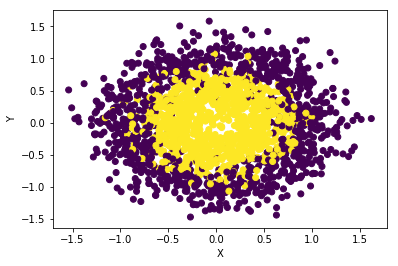

In [53]:
describe_dataset(4)

- **Class_balance** = Both classes are balanced.
- **Separability** = Samples are roughly arranged as concentric circular areas (class 0 is disc and class 1 is hollow disc), therefore we would need a circular decision boundry.
- **Noise** = Their is noise in dataset. The sepration between both dataset is almost missing. 

## Part (ii)

In [54]:
def linear_kernel(X,Y):
    return np.dot(X,Y.T)

In [55]:
def build_poly_kernel(degree):

    def poly_kernel(X,Y):
        return  (np.dot(X,Y.T)+1)**degree
    return poly_kernel

In [56]:
def radial_basis(x, y, gamma):
    return np.exp(-gamma * (np.linalg.norm(np.subtract(x, y)))**2)

In [57]:
def closure_function_rbf(gamma = 1):
    def build_rbf(X,Y):
        kernel_matrix = np.zeros((X.shape[0], Y.shape[0]))
        for i, x in enumerate(X):
            for j, y in enumerate(Y):
                kernel_matrix[i, j] = radial_basis(x, y,gamma)
        return kernel_matrix
    return build_rbf

In [58]:
# np.exp(-1*(np.linalg.norm(np.subtract(a, b),axis=1))**2)

In [59]:
def plot_decision_boundary(clf,X,Y):
    color = Y
    h = .02
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = predict_own(clf,X,np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:,0], X[:,1], c = color, cmap=plt.cm.coolwarm)
    plt.xlabel("Feature1")
    plt.ylabel("Feature2")

In [60]:
def predict_own(clf,X_train,X_test,return_distance = False):
    coeff = clf.dual_coef_
    support_vector_index = clf.support_
    intercept = clf.intercept_
    kernel = clf.kernel
    values = np.dot(coeff,kernel(X_train[support_vector_index],X_test))+intercept
    if return_distance:
        return values[0]
    values = values>=0
    return values[0].astype(int)

In [287]:
def fit_binary_classifier(x,y,kernel):
    clf = SVC(kernel=kernel)
    clf.fit(x,y)
    return clf

In [122]:
def one_vs_one(X_train,Y_train,X_test,kernel):
    number_of_classes = len(np.unique(Y_train))
    pred_matrix = np.zeros((len(X_test),3),dtype=np.int32)
    for index,i in enumerate(itertools.combinations(range(number_of_classes), 2)):
        dataset_index = np.concatenate([np.where(Y_train==i[0])[0],np.where(Y_train==i[1])[0]])
        x_train = X_train[dataset_index]
        y_train = Y_train[dataset_index]
        y_train = np.where(y_train==i[0],0,1)
        clf = fit_binary_classifier(x_train,y_train,kernel)
        pred = predict_own(clf,x_train,X_test)
        pred = np.where(pred==0,i[0],i[1])
        pred_matrix[:,index]=pred
    return np.array([int(np.argmax(np.bincount(x))) for x in pred_matrix])

In [63]:
def one_vs_rest(X_train,Y_train,X_test,kernel):
    number_of_classes = len(np.unique(Y_train))
    pred_matrix = np.zeros((len(X_test),3))
    for i in range(number_of_classes):
        y_train = np.where(Y_train==i,1,0)
        clf = fit_binary_classifier(X_train,y_train,kernel)
        pred = predict_own(clf,X_train,X_test,return_distance=True)
        pred[pred<0] = 0
        pred_matrix[:,i] = pred
    return np.argmax(pred_matrix, axis=1)

In [249]:
def create_confusion_matrix(true_labels,pred_labels):
    number_of_classes = len(np.unique(true_labels))
    confusion_matrix = np.zeros([number_of_classes,number_of_classes],dtype=int)
    for i in range(number_of_classes):
        index_of_class = np.where(true_labels==i)[0]
        pred_values_for_class = pred_labels[index_of_class]
        unique, counts = np.unique(pred_values_for_class,return_counts=True)
        count_dict = dict(zip(unique,counts))
        for key in count_dict.keys():
            confusion_matrix[i][key] = count_dict[key]
    return confusion_matrix

In [201]:
def plot_confusion_matrix(cm,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[0])
    plt.xticks(tick_marks, range(cm.shape[0]))
    plt.yticks(tick_marks, range(cm.shape[0]))

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [206]:
def plot_ROC_curve_for_binary_problem(false_pr,true_pr,roc_auc,dataset_number):
    plt.figure()
    plt.title(f'Receiver Operating Characteristic curve for {dataset_number}')
    plt.plot(false_pr, true_pr, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

### Dataset 1

In [264]:
X,Y = get_dataset(1)

In [265]:
clf = fit_binary_classifier(X,Y,build_poly_kernel(2))

In [266]:
pred = predict_own(clf,X,X)

In [267]:
accuracy_score(Y,pred)

1.0

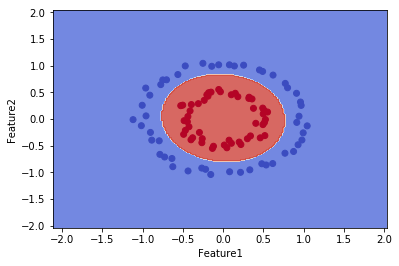

In [268]:
plot_decision_boundary(clf,X,Y)

### Dataset 2

In [269]:
X,Y = get_dataset(2)

In [270]:
clf = fit_binary_classifier(X,Y,build_poly_kernel(3))

In [271]:
pred = predict_own(clf,X,X)

In [272]:
accuracy_score(Y,pred)

1.0

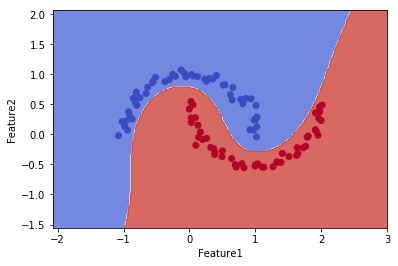

In [273]:
plot_decision_boundary(clf,X,Y)

### Dataset 3 (one vs one)

In [274]:
X,Y = get_dataset(3)

In [275]:
%%time
pred = one_vs_one(X,Y,X,linear_kernel)

CPU times: user 4.31 ms, sys: 4.01 ms, total: 8.32 ms
Wall time: 4.6 ms


In [276]:
accuracy_score(Y,pred)

1.0

Text(0,0.5,'Feature2')

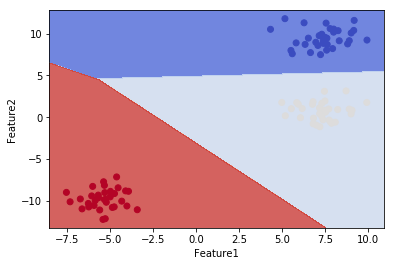

In [277]:
color = Y
h = .02
x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = one_vs_one(X,Y,np.c_[xx.ravel(), yy.ravel()],linear_kernel)
# Z = predict_own(clf,X,np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:,0], X[:,1], c = color, cmap=plt.cm.coolwarm)
plt.xlabel("Feature1")
plt.ylabel("Feature2")

### Dataset 3 (One vs Rest)

In [278]:
X,Y = get_dataset(3)

In [279]:
%%time
pred = one_vs_rest(X,Y,X,linear_kernel)

CPU times: user 6.6 ms, sys: 0 ns, total: 6.6 ms
Wall time: 3.73 ms


In [280]:
accuracy_score(Y,pred)

0.99

Text(0,0.5,'Feature2')

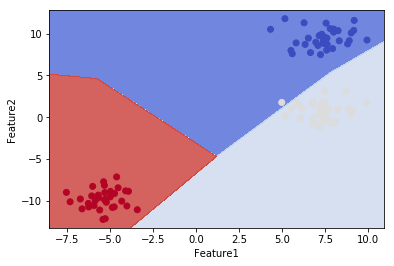

In [281]:
color = Y
h = .02
x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = one_vs_rest(X,Y,np.c_[xx.ravel(), yy.ravel()],linear_kernel)
# Z = predict_own(clf,X,np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:,0], X[:,1], c = color, cmap=plt.cm.coolwarm)
plt.xlabel("Feature1")
plt.ylabel("Feature2")

### Dataset 4

In [282]:
X,Y = get_dataset(4)

In [283]:
clf = fit_binary_classifier(X,Y,build_poly_kernel(2))

In [284]:
pred = predict_own(clf,X,X)

In [285]:
accuracy_score(Y,pred)

0.8825

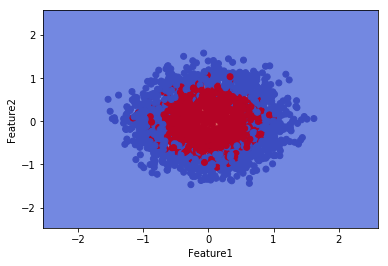

In [286]:
plot_decision_boundary(clf,X,Y)

## Part (iii) and (iv)

In [204]:
def split_80_20_predict(dataset_number,kernel):
    X,Y = get_dataset(dataset_number)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    clf = fit_binary_classifier(X_train,Y_train,kernel)
    pred = predict_own(clf,X_train,X_test)
    print(f"Train accuarcy {accuracy_score(Y_train,predict_own(clf,X_train,X_train))}")
    print(f"Test accuarcy {accuracy_score(Y_test,pred)}")
    print(f"Micro average F1 score {f1_score(Y_test,pred,average='micro')}")
    print(f"F1 score of each class {f1_score(Y_test,pred,average=None)}")
    plot_confusion_matrix(create_confusion_matrix(Y_test,pred),title=f"Confusion Matrix for dataset {dataset_number}")
    
    pred_prob = predict_own(clf,X_train,X_test,return_distance=True)
    false_pr, true_pr, thresholds = roc_curve(Y_test, pred_prob)
    roc_auc = auc(false_pr, true_pr)
    plot_ROC_curve_for_binary_problem(false_pr,true_pr,roc_auc,dataset_number)

### Dataset 1

Train accuarcy 0.525
Test accuarcy 0.4
Micro average F1 score 0.4000000000000001
F1 score of each class [0.57142857 0.        ]


/home/hitkul/anaconda3/envs/ml_ass/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


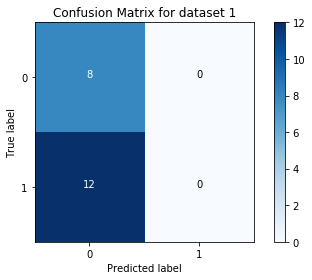

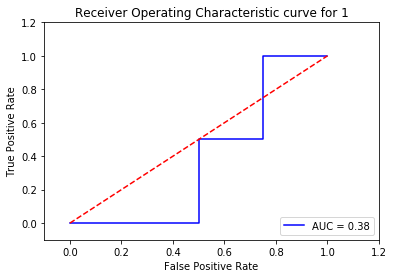

In [207]:
split_80_20_predict(1,linear_kernel)

Train accuarcy 1.0
Test accuarcy 1.0
Micro average F1 score 1.0
F1 score of each class [1. 1.]


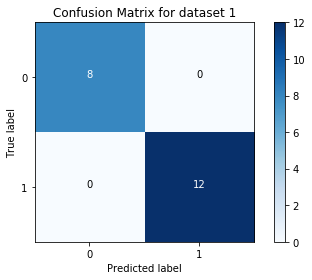

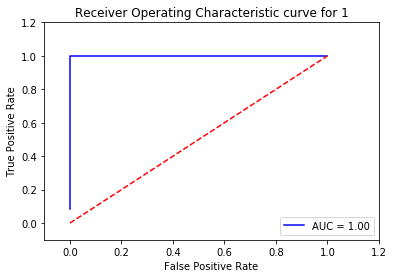

In [208]:
split_80_20_predict(1,closure_function_rbf())

### Dataset 2

Train accuarcy 0.875
Test accuarcy 0.8
Micro average F1 score 0.8000000000000002
F1 score of each class [0.81818182 0.77777778]


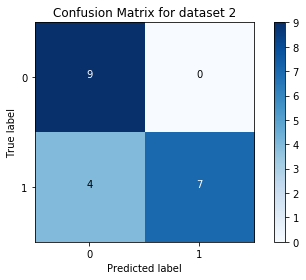

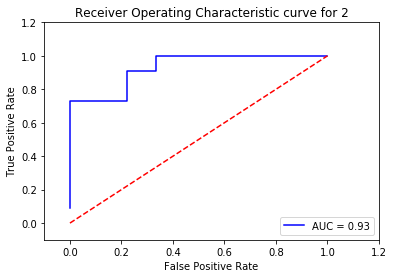

In [209]:
split_80_20_predict(2,linear_kernel)

Train accuarcy 1.0
Test accuarcy 0.95
Micro average F1 score 0.9500000000000001
F1 score of each class [0.94736842 0.95238095]


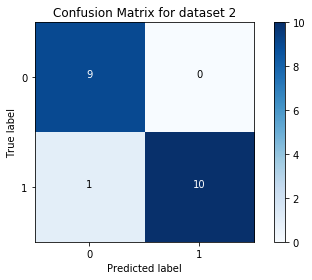

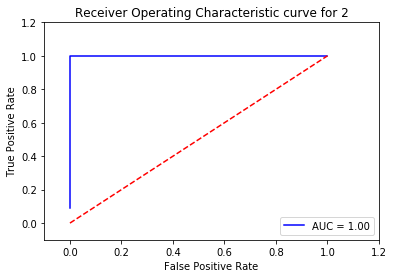

In [210]:
split_80_20_predict(2,closure_function_rbf())

### Dataset 3 (One vs One)

In [178]:
X,Y = get_dataset(3)

In [179]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [180]:
pred_test= one_vs_one(X_train,Y_train,X_test,linear_kernel)
pred_train= one_vs_one(X_train,Y_train,X_train,linear_kernel)

Train accuarcy 1.0
Test accuarcy 1.0
Micro average F1 score 1.0
F1 score of each class [1. 1. 1.]


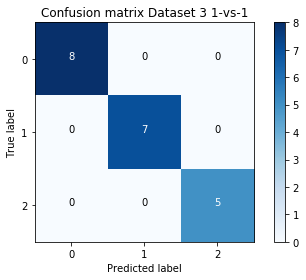

In [181]:
print(f"Train accuarcy {accuracy_score(Y_train,pred_train)}")
print(f"Test accuarcy {accuracy_score(Y_test,pred_test)}")
print(f"Micro average F1 score {f1_score(Y_test,pred_test,average='micro')}")
print(f"F1 score of each class {f1_score(Y_test,pred_test,average=None)}")
plot_confusion_matrix(create_confusion_matrix(Y_test,pred_test),title="Confusion matrix Dataset 3 1-vs-1")

In [182]:
pred_test = one_vs_one(X_train,Y_train,X_test,closure_function_rbf())
pred_train = one_vs_one(X_train,Y_train,X_train,closure_function_rbf())

Train accuarcy 1.0
Test accuarcy 1.0
Micro average F1 score 1.0
F1 score of each class [1. 1. 1.]


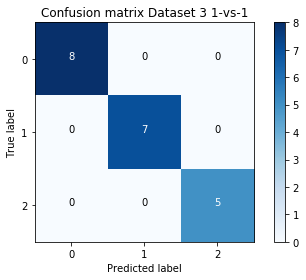

In [183]:
print(f"Train accuarcy {accuracy_score(Y_train,pred_train)}")
print(f"Test accuarcy {accuracy_score(Y_test,pred_test)}")
print(f"Micro average F1 score {f1_score(Y_test,pred_test,average='micro')}")
print(f"F1 score of each class {f1_score(Y_test,pred_test,average=None)}")
plot_confusion_matrix(create_confusion_matrix(Y_test,pred_test),title="Confusion matrix Dataset 3 1-vs-1")

### Dataset 3 (One vs Rest)

In [184]:
X,Y = get_dataset(3)

In [185]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [186]:
pred_test = one_vs_rest(X_train,Y_train,X_test,linear_kernel)
pred_train = one_vs_rest(X_train,Y_train,X_train,linear_kernel)

Train accuarcy 1.0
Test accuarcy 0.95
Micro average F1 score 0.9500000000000001
F1 score of each class [0.94117647 0.92307692 1.        ]


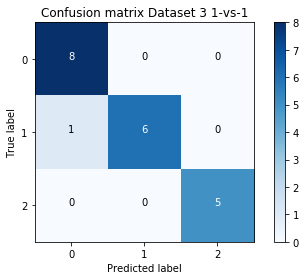

In [187]:
print(f"Train accuarcy {accuracy_score(Y_train,pred_train)}")
print(f"Test accuarcy {accuracy_score(Y_test,pred_test)}")
print(f"Micro average F1 score {f1_score(Y_test,pred_test,average='micro')}")
print(f"F1 score of each class {f1_score(Y_test,pred_test,average=None)}")
plot_confusion_matrix(create_confusion_matrix(Y_test,pred_test),title="Confusion matrix Dataset 3 1-vs-1")

In [188]:
pred_test = one_vs_rest(X_train,Y_train,X_test,closure_function_rbf())
pred_train = one_vs_rest(X_train,Y_train,X_train,closure_function_rbf())

Train accuarcy 1.0
Test accuarcy 0.95
Micro average F1 score 0.9500000000000001
F1 score of each class [0.94117647 0.92307692 1.        ]


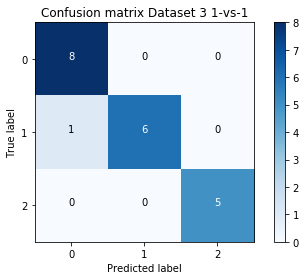

In [189]:
print(f"Train accuarcy {accuracy_score(Y_train,pred_train)}")
print(f"Test accuarcy {accuracy_score(Y_test,pred_test)}")
print(f"Micro average F1 score {f1_score(Y_test,pred_test,average='micro')}")
print(f"F1 score of each class {f1_score(Y_test,pred_test,average=None)}")
plot_confusion_matrix(create_confusion_matrix(Y_test,pred_test),title="Confusion matrix Dataset 3 1-vs-1")

### Dataset 4

Train accuarcy 0.549375
Test accuarcy 0.5275
Micro average F1 score 0.5275
F1 score of each class [0.45845272 0.58093126]


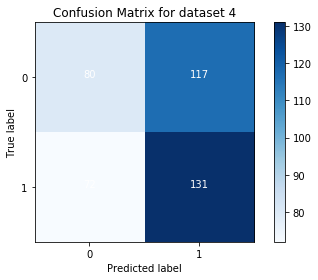

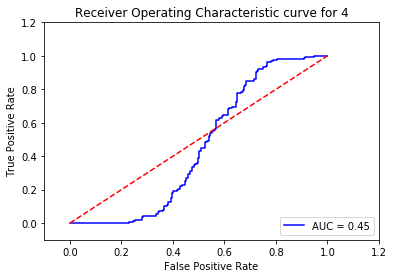

In [211]:
split_80_20_predict(4,linear_kernel)

Train accuarcy 0.88875
Test accuarcy 0.8875
Micro average F1 score 0.8875
F1 score of each class [0.88491049 0.88997555]


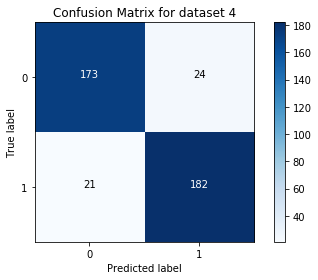

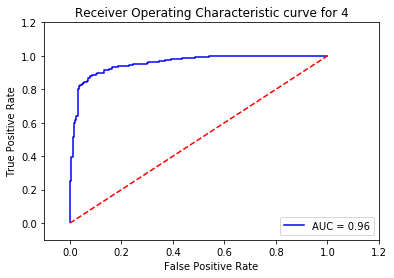

In [212]:
split_80_20_predict(4,closure_function_rbf())

## Part (v)

In [237]:
train_set_location = 'Hindi_dataset/Train_val/'
test_set_location = 'Hindi_dataset/Test/'

In [238]:
def read_image(image_location):
    img = Image.open(image_location).convert('L')
    arr = np.array(img.getdata(), dtype=np.uint8)
    arr[arr>0] = 1
    return arr

In [239]:
def read_data_set(data_location,test_set_flag=False):
    class_names = listdir(data_location)
    sample_per_class = 1700
    if test_set_flag:
        sample_per_class=300
    X = np.empty([sample_per_class*len(class_names),1024])
    Y = np.empty([sample_per_class*len(class_names),],dtype=int)
    for class_number,name in enumerate(class_names):
        for i,image_name in enumerate(listdir(data_location+name)):
            X[class_number*sample_per_class + i] = read_image(data_location+name+"/"+image_name)
            Y[class_number*sample_per_class + i] = class_number
    return X,Y

In [261]:
def plot_multi_class_ROC_curve(clf,X_test,y_test):
    y_score = clf.decision_function(X_test)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lw=2
    n_classes = len(np.unique(y_test))
    y_test = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")

In [241]:
X_train,Y_train = read_data_set(train_set_location)

In [242]:
X_test,Y_test = read_data_set(test_set_location,test_set_flag=True)

In [243]:
X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

((8500, 1024), (8500,), (1500, 1024), (1500,))

In [222]:
kfold = KFold(5, True, 1)

In [223]:
validation_results =[]
train_results = []

In [224]:
for train,validation in kfold.split(X_train):
    x_t = X_train[train]
    y_t = Y_train[train]
    x_v = X_train[validation]
    y_v = Y_train[validation]
    clf = SVC()
    clf.fit(x_t,y_t)
    pred_t = clf.predict(x_t)
    pred_v = clf.predict(x_v)
    validation_results.append(accuracy_score(y_v,pred_v))
    train_results.append(accuracy_score(y_t,pred_t))

In [225]:
train_results

[0.9460294117647059,
 0.9454411764705882,
 0.9436764705882353,
 0.9452941176470588,
 0.9494117647058824]

In [226]:
validation_results

[0.9258823529411765,
 0.9323529411764706,
 0.9388235294117647,
 0.9376470588235294,
 0.9211764705882353]

In [227]:
f"Train set accuarcy = {np.mean(train_results)} ± {np.std(train_results)}"

'Train set accuarcy = 0.9459705882352942 ± 0.0018892337473825611'

In [228]:
f"Validation set accuarcy = {np.mean(validation_results)} ± {np.std(validation_results)}"

'Validation set accuarcy = 0.9311764705882354 ± 0.006778757783947269'

In [244]:
clf = SVC()

In [245]:
clf.fit(X_train,Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [246]:
pred = clf.predict(X_test)

Test accuarcy 0.9413333333333334
Micro average F1 score 0.9413333333333334
F1 score of each class [0.96333333 0.91585761 0.91311755 0.9484193  0.96632997]


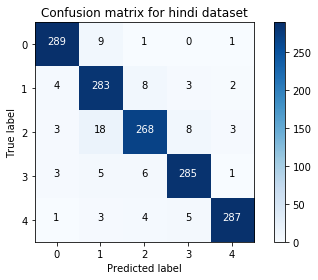

In [250]:
print(f"Test accuarcy {accuracy_score(Y_test,pred)}")
print(f"Micro average F1 score {f1_score(Y_test,pred,average='micro')}")
print(f"F1 score of each class {f1_score(Y_test,pred,average=None)}")
plot_confusion_matrix(create_confusion_matrix(Y_test,pred),title="Confusion matrix for hindi dataset")

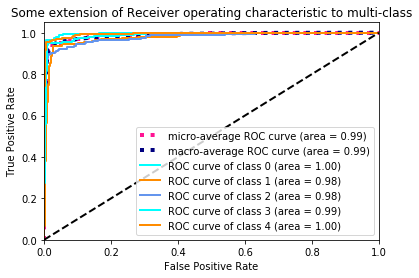

In [262]:
plot_multi_class_ROC_curve(clf,X_test,Y_test)